In [81]:
from torch.utils.data import Dataset
import os
import torch
from tqdm import tqdm
from scipy.interpolate import interp1d
from dtw import dtw

class OfflineTrajectoryDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = [os.path.join(data_dir, file) for file in sorted(os.listdir(data_dir))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        data = torch.load(file)
        
        length = data['rgbs'].shape[0]
        padding_size = 500 - length
        
        rgbs = torch.nn.functional.pad(data['rgbs'], (0, 0, 0, padding_size), "constant", 0)
        actions = torch.nn.functional.pad(torch.tensor(data['actions']), (0, padding_size), "constant", 0)
        coords = data['coords']
        info = {
            "length": length,
            "episode_id": data['episode_id'],
            "scene_id": data['scene_id'],
            "trajectory_id": data['trajectory_id']
        }
        return rgbs, data['imagegoal'], coords, actions, info

def cache_into_list(dataset):
    return [item for item in tqdm(dataset)]

def find_trajectories_by_episode(dataset, episode_id):
    return [dataset[i] for i in range(len(dataset)) if dataset[i][-1]['episode_id'] == episode_id]

import numpy as np


def euclidean_dist(a, b):
    return np.linalg.norm(np.array(a) - np.array(b), ord=2)


def interpolate_point_pair(v1, v2, t):
    """
    interpolate between two points

    Args:
        v1: point 1
        v2: point 2
        t: parameterized variable

    Returns:

    """
    return tuple((1 - t) * x1 + t * x2 for x1, x2 in zip(v1, v2))


def resample_trajectory(points, num_samples):
    """
    Resample a set of points along a trajectory.

    :param points: A 2D numpy array of shape [N, 2], representing (x, y) coordinates.
    :param num_samples: The number of points to resample along the trajectory.
    :return: A 2D numpy array of resampled points.
    """
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]

    # Compute the cumulative distance along the trajectory
    distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    cumulative_distance = np.insert(np.cumsum(distances), 0, 0)

    # Create a linear interpolator for each coordinate
    interpolator_x = interp1d(cumulative_distance, x, kind='linear')
    interpolator_y = interp1d(cumulative_distance, y, kind='linear')

    # Generate equally spaced distances along the trajectory
    distance_samples = np.linspace(0, cumulative_distance[-1], num_samples)

    # Resample points
    resampled_x = interpolator_x(distance_samples)
    resampled_y = interpolator_y(distance_samples)

    return np.vstack((resampled_x, resampled_y)).T

def compute_ndtw(query, ref, success_dist, return_dtw=False):
    """
    computes normalized dynamic time warping metric
    Args:
        query:
        ref:
        success_dist:

    Returns:

    """
    dtw_dist, cost_matrix, acc_cost_matrix, path = dtw(query, ref, dist=euclidean_dist)

    nDTW = np.exp(-(dtw_dist / (len(ref) * success_dist)))

    if return_dtw:
        return nDTW, dtw_dist

    return nDTW

def plot_multiple_trajectories(trajectories):
    """
    Plot multiple trajectories on a single plot.

    :param trajectories: A list of 2D numpy arrays, each representing a trajectory.
    """
    plt.figure(figsize=(10, 6))

    for i, trajectory in enumerate(trajectories):
        plt.plot(trajectory[:, 0], trajectory[:, 1], 'o-', label=f'Trajectory {i+1}')

    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Multiple Trajectories')
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
dataset = OfflineTrajectoryDataset("/srv/flash1/pputta7/projects/lm-nav/data/datasets/lmnav/offline_1env_karmesh+clip")
data = cache_into_list(dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29319/29319 [03:49<00:00, 127.82it/s]


In [84]:
trajectory_id = 0
num_points = 50
trajectories = list(map(lambda x: torch.tensor(x[2])[:, [0, 2]], find_trajectories_by_episode(data, trajectory_id)))
resampled_trajectories = [resample_trajectory(t, num_points) for t in trajectories]
dist_matrix = torch.zeros(len(resampled_trajectories), len(resampled_trajectories))
for i, x in enumerate(resampled_trajectories):
    for j, y in enumerate(resampled_trajectories):
        dist_matrix[i][j] = compute_ndtw(x, y, 1.0)

dist_matrix

tensor([[1.0000, 0.1124, 0.6442, 0.6528],
        [0.1124, 1.0000, 0.2371, 0.2058],
        [0.6442, 0.2371, 1.0000, 0.8569],
        [0.6528, 0.2058, 0.8569, 1.0000]])

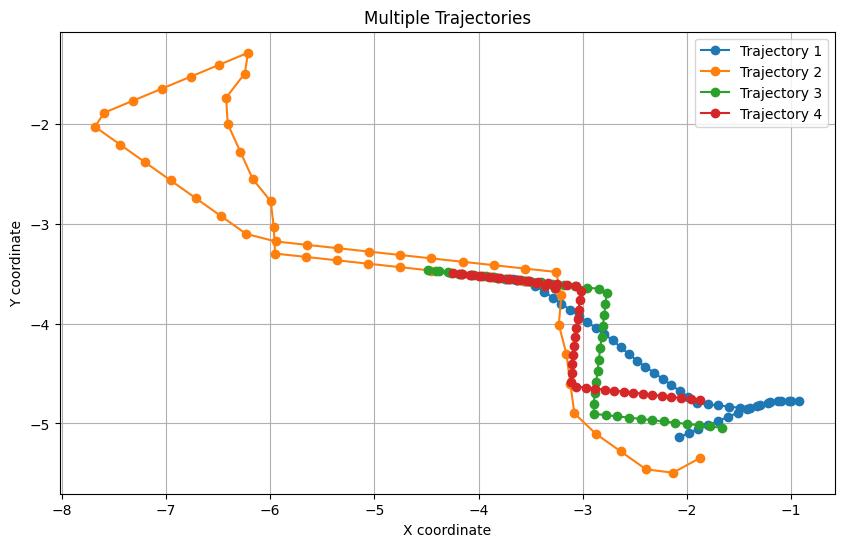

In [85]:
plot_multiple_trajectories(resampled_trajectories)

In [44]:
from dtw import dtw